# Predykcja czasu dostawy zamówienia


## Treść zadania
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy
wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą
informację klientom.

## Poziom biznesowy

### Zadanie biznesowe
Celem tego projektu jest dodanie przewidywania czasu dostawy dla każdego z zamówień dokonanych przez klientów. Dostarczenie takiej informacji klientom powinno pozytywnie wpłynąć na ich zadowolenie z korzystania z naszego sklepu internetowego. To z kolei sprawi, że częściej będą korzystać z naszych usług.

### Biznesowe kryterium sukcesu
System w dobrym stopniu estymuje czas dostawy dla każdego zamówienia.

## Poziom analityczny

### Zadanie modelowania
Czas dostawy to wartość ciągła, stąd też problem sprowadza się do zadania regresji.

### Analityczne kryterium sukcesu
Wartość RMSE dla przewidywanego czasu dostawy nie przekracza 5 godzin.

### Założenia
* Model obsługiwać będzie tylko te kategorie produktów, które pojawiają się w danych uczących

## Wczytanie danych z plików

In [1]:
#installs pandasql within jupyter kernel
%pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import time
import pandas as pd
from pandasql import sqldf

In [3]:
deliveriesFile = open("IUM21L_Zad_03_02/deliveries.jsonl", "r")
productsFile = open("IUM21L_Zad_03_02/products.jsonl", "r")
sessionsFile = open("IUM21L_Zad_03_02/sessions.jsonl", "r")
usersFile = open("IUM21L_Zad_03_02/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

print(deliveries[0].keys())
print(products[0].keys())
print(sessions[0].keys())
print(users[0].keys())

dict_keys(['purchase_id', 'purchase_timestamp', 'delivery_timestamp', 'delivery_company'])
dict_keys(['product_id', 'product_name', 'category_path', 'price'])
dict_keys(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type', 'offered_discount', 'purchase_id'])
dict_keys(['user_id', 'name', 'city', 'street'])


In [4]:
deliveriesDF = pd.DataFrame.from_dict(deliveries)
productsDF = pd.DataFrame.from_dict(products)
sessionsDF = pd.DataFrame.from_dict(sessions)
usersDF = pd.DataFrame.from_dict(users)

In [5]:
pysqldf = lambda q: sqldf(q, globals())
dataDF = pysqldf("SELECT * FROM sessionsDF s JOIN deliveriesDF d ON s.purchase_id = d.purchase_id JOIN productsDF p ON s.product_id = p.product_id JOIN usersDF u ON s.user_id = u.user_id;")
projectedDataDF = pysqldf("SELECT purchase_timestamp, delivery_timestamp, delivery_company, offered_discount, product_name, price, category_path, name, city, street FROM dataDF;")

In [6]:
pysqldf("SELECT * FROM projectedDataDF LIMIT 0;")

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street


In [7]:
#pysqldf("SELECT COUNT(*) FROM dataDF WHERE event_type = \"VIEW_PRODUCT\";")
#pysqldf("SELECT name, city, street, COUNT(*) count FROM projectedDataDF WHERE purchase_timestamp > delivery_timestamp GROUP BY name;")
pysqldf("SELECT count(*) FROM projectedDataDF WHERE purchase_timestamp > delivery_timestamp;")

,count(*)
0,1963


## Wykorzystywane funkcje

In [8]:
# Convert date to unix timestamp (seconds only)
def dateToTimestamp(date):
    date = date.split('.')[0]
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()
    return time.mktime(date)

def timestampToDate(timestamp):
    return datetime.fromtimestamp(timestamp).strftime("%Y-%m-%dT%H:%M:%S")

## Analiza danych

### Ceny produktów

Niektóre ceny są błędne - ujemne lub bardzo duże

In [9]:
products.sort(key=lambda product : product["price"])
print("Price \t Product")
for product in products:
    print(str(product["price"])+"\t"+product["product_name"])

Price 	 Product
-142.99	Race Driver Grid (PC)
-121.9	The Darkness 2 (PC)
-112.28	Sencor SDA-500
-109.0	Fight Night Champion (PS3)
-79.9	Assassin&#39;s Creed 3 (PS3)
-69.99	Sencor SDA-600
-49.99	Assassin&#39;s Creed 3 (Xbox 360)
-39.0	Sniper Ghost Warrior 2 (Xbox 360)
-37.9	Bioshock 2 (PC)
-32.99	Call of Duty Black Ops 2 (PC)
-19.99	Symulator Agrar 2012 (PC)
-19.99	Space Hack (PC)
-14.9	Sniper Ghost Warrior (PC)
-11.9	Street Racing Syndicate (PC)
-9.99	King&#39;s Bounty Nowe Światy (PC)
-1.0	Król Futbolu Piłkarski Quiz (PC)
1.0	Heroes Over Europe (PC)
1.0	The Ball (PC)
1.99	Street Fighter 4 (PC)
3.0	Dragonshard (PC)
3.59	Hearts of Iron 2 (PC)
4.9	Dream Pinball 3D (PC)
4.99	Cities in Motion (PC)
4.99	A New Beginning (PC)
4.99	Rig&#39;n&#39;Roll Tirowiec (PC)
4.99	Symulator Kamieniołomu (PC)
5.0	Symulator Zamiatarki ulic (PC)
7.9	Warhammer 40.000 Space Marine (PC)
8.9	Singularity (PC)
8.99	MAJESTY ANTOLOGIA (PC)
8.99	Euro Truck Simulator (PC)
9.99	Bus Driver (PC)
9.99	Hard Reset (PC)
9.99

### Analiza czasu dostawy

In [10]:
N_SECONDS = 3600.0

correctDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE purchase_timestamp < delivery_timestamp")

#create columns
correctDataDF["purchase_timestamp_sec"] = 0
correctDataDF["delivery_timestamp_sec"] = 0
correctDataDF["delivery_time_h"] = 0.0
correctDataDF["purchase_day_name"] = ""
correctDataDF["delivery_day_name"] = ""

for index, _ in correctDataDF.iterrows():
    correctDataDF.at[index, "purchase_timestamp_sec"] = dateToTimestamp(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp_sec"] = dateToTimestamp(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_time_h"] = float(correctDataDF["delivery_timestamp_sec"].iloc[index] - correctDataDF["purchase_timestamp_sec"].iloc[index]) / N_SECONDS
    correctDataDF.at[index, "purchase_timestamp"] = pd.to_datetime(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp"] = pd.to_datetime(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "purchase_day_name"] = correctDataDF["purchase_timestamp"].iloc[index].day_name()
    correctDataDF.at[index, "delivery_day_name"] = correctDataDF["delivery_timestamp"].iloc[index].day_name()

correctDataDF

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street,purchase_timestamp_sec,delivery_timestamp_sec,delivery_time_h,purchase_day_name,delivery_day_name
0,2021-03-07 03:52:21,2021-03-08 23:29:47.065546,620.0,15,Kyocera FS-3540MFP,5126.00,Komputery;Drukarki i skanery;Biurowe urządzeni...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615085541,1615242587,43.623889,Sunday,Monday
1,2021-03-08 12:51:20,2021-03-10 08:56:30.356048,620.0,0,Manta DVD064,109.00,Sprzęt RTV;Video;Odtwarzacze DVD,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615204280,1615362990,44.086111,Monday,Wednesday
2,2021-03-07 11:10:10,2021-03-07 15:10:29.594621,360.0,0,Plantronics Voyager Legend,249.00,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615111810,1615126229,4.005278,Sunday,Sunday
3,2021-03-14 11:12:10,2021-03-18 08:56:17.888575,360.0,15,Samsung Galaxy S III GT-i9300,2199.90,Telefony i akcesoria;Telefony komórkowe,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1615716730,1616054177,93.735278,Sunday,Thursday
4,2021-02-15 02:50:22,2021-02-15 14:10:14.870034,516.0,5,Hama 44292,44.99,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Julianna Wójcikiewicz,Szczecin,pl. Szczęśliwa 91/41,1613353822,1613394614,11.331111,Monday,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4590,2021-02-21 17:44:13,2021-02-23 07:42:42.799867,620.0,20,Philips SDV5100,119.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Leonard Noras,Konin,ulica Szeroka 91/08,1613925853,1614062562,37.974722,Sunday,Tuesday
4591,2021-03-11 21:11:18,2021-03-12 12:15:15.908504,516.0,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Leonard Noras,Konin,ulica Szeroka 91/08,1615493478,1615547715,15.065833,Thursday,Friday
4592,2021-01-14 21:47:35,2021-01-14 22:27:30.495168,620.0,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Leonard Noras,Konin,ulica Szeroka 91/08,1610657255,1610659650,0.665278,Thursday,Thursday
4593,2021-01-16 12:36:17,2021-01-17 01:48:18.440661,620.0,10,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Leonard Noras,Konin,ulica Szeroka 91/08,1610796977,1610844498,13.200278,Saturday,Sunday


In [23]:
pysqldf("SELECT city, AVG(delivery_time_h) FROM correctDataDF GROUP BY city ORDER BY AVG(delivery_time_h);")

,city,AVG(delivery_time_h)
0,Warszawa,47.592224
1,Police,47.874228
2,Konin,48.601555
3,Szczecin,48.620962
4,Radom,48.956674
5,Mielec,49.028544
6,Gdynia,50.004451
7,Kutno,50.410385


In [98]:
correctDataDF.groupby("city").agg(
    count_city=("city", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_city,mean_delivery_time_h,std_delivery_time_h
city,,,
Warszawa,736,47.592224,33.033617
Police,433,47.874228,33.554049
Konin,538,48.601555,31.851092
Szczecin,431,48.620962,32.379566
Radom,693,48.956674,36.203805
Mielec,753,49.028544,33.714425
Gdynia,522,50.004451,35.445027
Kutno,489,50.410385,34.196164


Jak widać, czas dostawy nie zależy zbytnio od miasta, w którym znajduje się klient. Być może oznacza to, że firma ma oddziały we wszystkich tych miastach.

In [12]:
pysqldf("SELECT purchase_day_name, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY purchase_day_name ORDER BY AVG(delivery_time_h);")

,purchase_day_name,COUNT(*),AVG(delivery_time_h)
0,Monday,652,47.799079
1,Saturday,684,48.120035
2,Wednesday,596,48.471003
3,Thursday,643,48.943231
4,Tuesday,614,49.371340
5,Friday,661,49.492935
6,Sunday,745,49.653701


In [96]:
correctDataDF.groupby("purchase_day_name").agg(
    count_purchase_day_name=("purchase_day_name", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_purchase_day_name,mean_delivery_time_h,std_delivery_time_h
purchase_day_name,,,
Monday,652,47.799079,34.202574
Saturday,684,48.120035,33.448366
Wednesday,596,48.471003,33.905495
Thursday,643,48.943231,32.906153
Tuesday,614,49.371340,35.062654
Friday,661,49.492935,33.847304
Sunday,745,49.653701,33.957088


Czas dostawy nie zależy też od dnia tygodnia, w którym dokonano zakupu.

In [13]:
pysqldf("SELECT delivery_day_name, COUNT(*) FROM correctDataDF GROUP BY delivery_day_name ORDER BY COUNT(*);")

,delivery_day_name,COUNT(*)
0,Thursday,622
1,Saturday,627
2,Friday,648
3,Wednesday,662
4,Sunday,667
5,Monday,676
6,Tuesday,693


In [100]:
correctDataDF.groupby("delivery_day_name").agg(
    count_delivery_day_name=("delivery_day_name", "count")
).sort_values(by="count_delivery_day_name")

,count_delivery_day_name
delivery_day_name,
Thursday,622
Saturday,627
Friday,648
Wednesday,662
Sunday,667
Monday,676
Tuesday,693


Nasi kurierzy działają równie sprawnie w weekendy jak i w pozostałe dni tygodnia.

In [14]:
pysqldf("SELECT category_path, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY category_path ORDER BY AVG(delivery_time_h);")

,category_path,COUNT(*),AVG(delivery_time_h)
0,Sprzęt RTV;Video;Odtwarzacze DVD,295,43.177488
1,Sprzęt RTV;Przenośne audio i video;Odtwarzacze...,313,45.001198
2,Komputery;Drukarki i skanery;Biurowe urządzeni...,332,45.213013
3,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,326,47.860112
4,Komputery;Tablety i akcesoria;Tablety,290,48.054924
5,Gry i konsole;Gry na konsole;Gry Xbox 360,286,48.939038
6,Sprzęt RTV;Audio;Słuchawki,332,49.004354
7,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,307,49.442234
8,Telefony i akcesoria;Telefony komórkowe,314,49.564618
9,Sprzęt RTV;Video;Telewizory i akcesoria;Okular...,312,50.284382


In [101]:
correctDataDF.groupby("category_path").agg(
    count_category_path=("category_path", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_category_path,mean_delivery_time_h,std_delivery_time_h
category_path,,,
Sprzęt RTV;Video;Odtwarzacze DVD,295,43.177488,28.847340
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,313,45.001198,32.148997
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,332,45.213013,34.096998
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,326,47.860112,31.838340
Komputery;Tablety i akcesoria;Tablety,290,48.054924,31.903575
Gry i konsole;Gry na konsole;Gry Xbox 360,286,48.939038,33.989175
Sprzęt RTV;Audio;Słuchawki,332,49.004354,33.721106
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,307,49.442234,34.177587
Telefony i akcesoria;Telefony komórkowe,314,49.564618,35.828951


Widać pewną zależność między kategorią produktu a czasem dostawy, jednak nie jest ona bardzo wyraźna.

In [15]:
pysqldf("SELECT delivery_company, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY delivery_company ORDER BY AVG(delivery_time_h);")

,delivery_company,COUNT(*),AVG(delivery_time_h)
0,620.0,1454,47.238538
1,NaN,218,48.555042
2,360.0,1462,49.116755
3,516.0,1461,50.226304


In [102]:
correctDataDF.groupby("delivery_company").agg(
    count_delivery_company=("delivery_company", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_delivery_company,mean_delivery_time_h,std_delivery_time_h
delivery_company,,,
620.0,1454,47.238538,32.535415
360.0,1462,49.116755,34.182565
516.0,1461,50.226304,34.964884


Z powyższej analizy wynika, że wybór firmy kurierskiej nie wpływa znacznie na czas dostawy.

In [16]:
pysqldf("SELECT offered_discount, COUNT(*), AVG(delivery_time_h) FROM correctDataDF GROUP BY offered_discount ORDER BY AVG(delivery_time_h);")

,offered_discount,COUNT(*),AVG(delivery_time_h)
0,5,439,47.309820
1,10,485,48.388797
2,15,503,48.513149
3,20,506,48.754345
4,0,2662,49.267382


In [103]:
correctDataDF.groupby("offered_discount").agg(
    count_offered_discount=("offered_discount", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_offered_discount,mean_delivery_time_h,std_delivery_time_h
offered_discount,,,
5,439,47.309820,33.947263
10,485,48.388797,32.925670
15,503,48.513149,34.699098
20,506,48.754345,32.734537
0,2662,49.267382,34.120161


Oferowana zniżka też w żaden wyraźny sposób nie wpływa na czas dostawy.

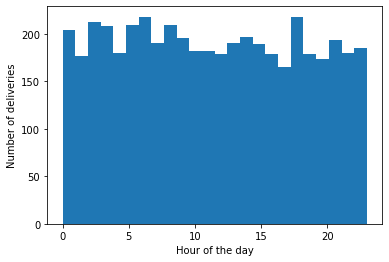

In [17]:
delivery_hours = []

for index, _ in correctDataDF.iterrows():
    delivery_hours.append(correctDataDF["delivery_timestamp"].iloc[index].hour)

plt.hist(delivery_hours, bins=24, density=False)
plt.xlabel("Hour of the day")
plt.ylabel("Number of deliveries")
plt.show()

Firmy kurierskie pracują przez całą dobę.

382 purchases not delivered
7258 purchases delivered


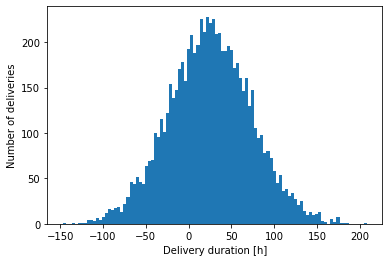

In [18]:
notDeliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is None]
deliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is not None]
print(str(len(notDeliveredList))+" purchases not delivered")
print(str(len(deliveredList))+" purchases delivered")

deliveryTimes = [dateToTimestamp(delivery['delivery_timestamp']) for delivery in deliveredList]
purchaseTimes = [dateToTimestamp(delivery['purchase_timestamp']) for delivery in deliveredList]

deliveryDurations = [(deliveryTime - purchaseTime)/3600 for deliveryTime, purchaseTime in zip(deliveryTimes, purchaseTimes)]

plt.hist(deliveryDurations, density=False, bins=100)
plt.ylabel('Number of deliveries')
plt.xlabel('Delivery duration [h]')
plt.show()

Company 620
2321 deliveries


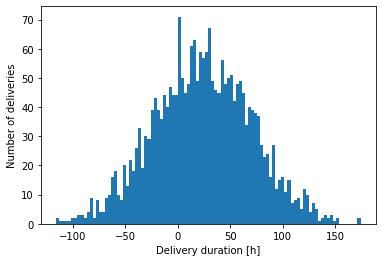

Company None
337 deliveries


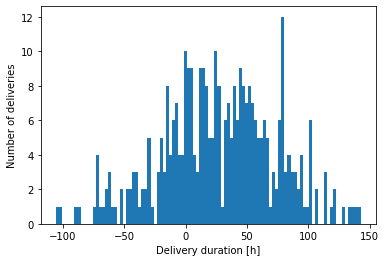

Company 516
2305 deliveries


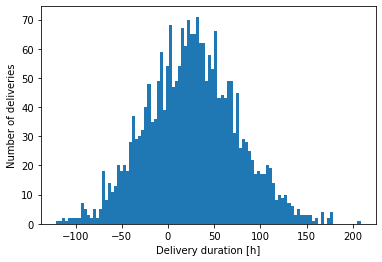

Company 360
2295 deliveries


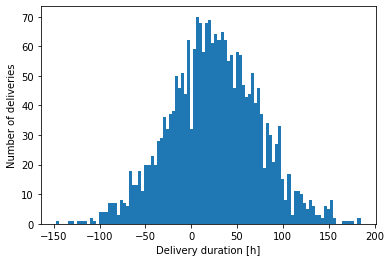

In [19]:
companies = []
for delivery in deliveries:
    if delivery['delivery_company'] not in companies:# and delivery['delivery_company'] is not None:
        companies.append(delivery['delivery_company'])

for company in companies:
    print('Company '+str(company))
    durations = []
    counter = 0
    for delivery in deliveredList:
        if delivery['delivery_company'] == company:
            counter += 1
            durations.append((dateToTimestamp(delivery['delivery_timestamp']) - dateToTimestamp(delivery['purchase_timestamp']))/3600)
    print(str(counter)+' deliveries')
    plt.hist(durations, density=False, bins=100)
    plt.ylabel('Number of deliveries')
    plt.xlabel('Delivery duration [h]')
    plt.show()